# Latest COVID-19 India Matplotlib Overview

In [1]:
#hide
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
from IPython.core.display import display,HTML
%matplotlib inline
from datetime import date

In [2]:
#hide
df  = pd.read_csv('https://api.covid19india.org/csv/latest/states.csv')
df = df[['Date','State','Confirmed','Deceased']]
df = df.rename(columns={'Confirmed':'Cases', "Deceased":'Deaths'})
df_cases = df[["Date",'State','Cases']]
df_deaths = df[['Date','State','Deaths']]
df_cases1 = df_cases.groupby('Date')
df_deaths1= df_deaths.groupby('Date')

In [3]:
#hide
df_snap = pd.read_csv('data/SnapshotCases-28-July.csv')
arr_states = df_snap['states'].unique()
arr_dates = df['Date'].unique()
df_snap = df_snap.set_index('states')

In [4]:
#hide
arr_states[-9] = 'Puducherry'
arr_states[-10] = 'Odisha'
arr_states[6] = 'Dadra and Nagar Haveli and Daman and Diu'
arr_states = np.append(arr_states,np.array(['Chhattisgarh','Ladakh','Uttarakhand']))
arr_states

array(['Andaman and Nicobar Islands', 'Andhra Pradesh',
       'Arunachal Pradesh', 'Assam', 'Bihar', 'Chandigarh',
       'Dadra and Nagar Haveli and Daman and Diu', 'Delhi', 'Goa',
       'Gujarat', 'Haryana', 'Himachal Pradesh', 'Jammu and Kashmir',
       'Jharkhand', 'Karnataka', 'Kerala', 'Lakshadweep',
       'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram',
       'Nagaland', 'Odisha', 'Puducherry', 'Punjab', 'Rajasthan',
       'Sikkim', 'Tamil Nadu', 'Telangana', 'Tripura', 'Uttar Pradesh',
       'West Bengal', 'Chhattisgarh', 'Ladakh', 'Uttarakhand'],
      dtype=object)

In [5]:
#hide
dates = []
for i in arr_dates:
    if i>='2020-07-01':
        dates.append(i)
dict = {'states':dates}
for i in arr_states:
    dict[i] = [0]*len(dates)
dft_cases = pd.DataFrame(dict)
dft_deaths = pd.DataFrame(dict)


In [6]:
#hide
for i in range(len(dates)):
    df1_deaths = df_deaths1.get_group(dates[i])
    for j in range(len(df1_deaths.index)):
        if df1_deaths.iloc[j,1] in arr_states:
            dft_deaths.loc[i,df1_deaths.iloc[j,1]] = df1_deaths.iloc[j,2]
dft_deaths = dft_deaths.set_index('states')

In [7]:
#hide
for i in range(len(dates)):
    df1_cases = df_cases1.get_group(dates[i])
    for j in range(len(df1_cases.index)):
        if df1_cases.iloc[j,1] in arr_states:
            dft_cases.loc[i,df1_cases.iloc[j,1]] = df1_cases.iloc[j,2]
dft_cases = dft_cases.set_index('states')

In [8]:
#hide
dft_cases = dft_cases.T
dft_deaths = dft_deaths.T
dt_today = dates[-1]
dt_yday = dates[-2]

In [9]:
#hide
dft_cases = dft_cases.reset_index()
dft_deaths = dft_deaths.reset_index()
dft_cases = dft_cases.rename(columns = {'index':'state'})
dft_deaths = dft_deaths.rename(columns = {'index':'state'})

In [10]:
#hide
dfc_cases = dft_cases.groupby('state')[dt_today].sum()
dfc_deaths = dft_deaths.groupby('state')[dt_today].sum()
dfp_cases = dft_cases.groupby('state')[dt_yday].sum()
dfp_deaths = dft_deaths.groupby('state')[dt_yday].sum()

In [11]:
#hide
df_table = pd.DataFrame({'states': dfc_cases.index, 'Cases': dfc_cases.values, 'Deaths': dfc_deaths.values, 'PCases': dfp_cases.values, 'PDeaths': dfp_deaths.values}).set_index('states')
df_table = df_table.sort_values(by = ['Cases','Deaths'], ascending = [False, False])
df_table = df_table.reset_index()
df_table.head()

,states,Cases,Deaths,PCases,PDeaths
0,Maharashtra,1994977,50523,1992683,50473
1,Karnataka,933077,12181,932432,12175
2,Andhra Pradesh,886245,7142,886066,7141
3,Kerala,857381,3507,851195,3481
4,Tamil Nadu,831866,12281,831323,12272


In [12]:
#hide
for c in 'Cases, Deaths'.split(', '):
    df_table[f'{c} (+)'] = (df_table[c] - df_table[f'P{c}']).clip(0)
df_table['Fatality Rate'] = (100* df_table['Deaths']/ df_table['Cases']).round(2)

In [13]:
#hide
df_table.head()

,states,Cases,Deaths,PCases,PDeaths,Cases (+),Deaths (+),Fatality Rate
0,Maharashtra,1994977,50523,1992683,50473,2294,50,2.53
1,Karnataka,933077,12181,932432,12175,645,6,1.31
2,Andhra Pradesh,886245,7142,886066,7141,179,1,0.81
3,Kerala,857381,3507,851195,3481,6186,26,0.41
4,Tamil Nadu,831866,12281,831323,12272,543,9,1.48


In [14]:
#hide
summary = {'updated':dates[-1], 'since':dates[-2]}
list_names = ['Cases', 'PCases', 'Deaths', 'PDeaths', 'Cases (+)', 'Deaths (+)']
for name in list_names:
    summary[name] = df_table.sum()[name]
summary

{'updated': '2021-01-19',
 'since': '2021-01-18',
 'Cases': 10596228,
 'PCases': 10582662,
 'Deaths': 152747,
 'PDeaths': 152593,
 'Cases (+)': 13566,
 'Deaths (+)': 154}

In [15]:
#hide
overview = '''
<!-- #######  HTML!! #########-->
<h1 style="color: #5e9ca0; text-align: center;">India</h1>
<p style="text-align: center;">Last update: <strong>{update}</strong></p>
<p style="text-align: center;">Confirmed cases:</p>
<p style="text-align: center;font-size:24px;">{cases} (<span style="color: #ff0000;">+{new}</span>)</p>
<p style="text-align: center;">Confirmed deaths:</p>
<p style="text-align: center;font-size:24px;">{deaths} (<span style="color: #ff0000;">+{dnew}</span>)</p>
'''

In [16]:
#hide_input
update = summary['updated']
cases = summary['Cases']
new = summary['Cases (+)']
deaths = summary['Deaths']
dnew = summary['Deaths (+)']

html = HTML(overview.format(update=update, cases=cases,new=new,deaths=deaths,dnew=dnew))

display(html)

In [17]:
#hide
dt_cols = list(dft_cases.columns[1:])
dft_ct_new_cases = dft_cases.groupby('state')[dt_cols].sum().diff(axis=1).fillna(0).astype(int)
dft_ct_new_cases.sort_values(by = dates[-1], ascending = False,inplace = True)

In [18]:
#hide
dft_ct_new_cases.head()

states,2020-07-01,2020-07-02,2020-07-03,2020-07-04,2020-07-05,2020-07-06,2020-07-07,2020-07-08,2020-07-09,2020-07-10,...,2021-01-10,2021-01-11,2021-01-12,2021-01-13,2021-01-14,2021-01-15,2021-01-16,2021-01-17,2021-01-18,2021-01-19
state,,,,,,,,,,,,,,,,,,,,,
Kerala,0,160,211,240,225,193,272,301,339,416,...,4545,3110,5507,6004,5490,5624,5960,5005,3346,6186
Maharashtra,0,6328,6364,7074,6555,5368,5134,6603,6875,7862,...,3558,2438,2936,3556,3579,3145,2910,3081,1924,2294
Karnataka,0,1502,1694,1839,1925,1843,1498,2062,2228,2313,...,792,496,751,746,408,708,584,745,435,645
Tamil Nadu,0,4343,4329,4280,4150,3827,3616,3756,4231,3680,...,724,682,671,673,665,621,610,589,551,543
Gujarat,0,681,687,712,725,735,778,783,861,875,...,671,615,602,583,570,535,505,518,495,485


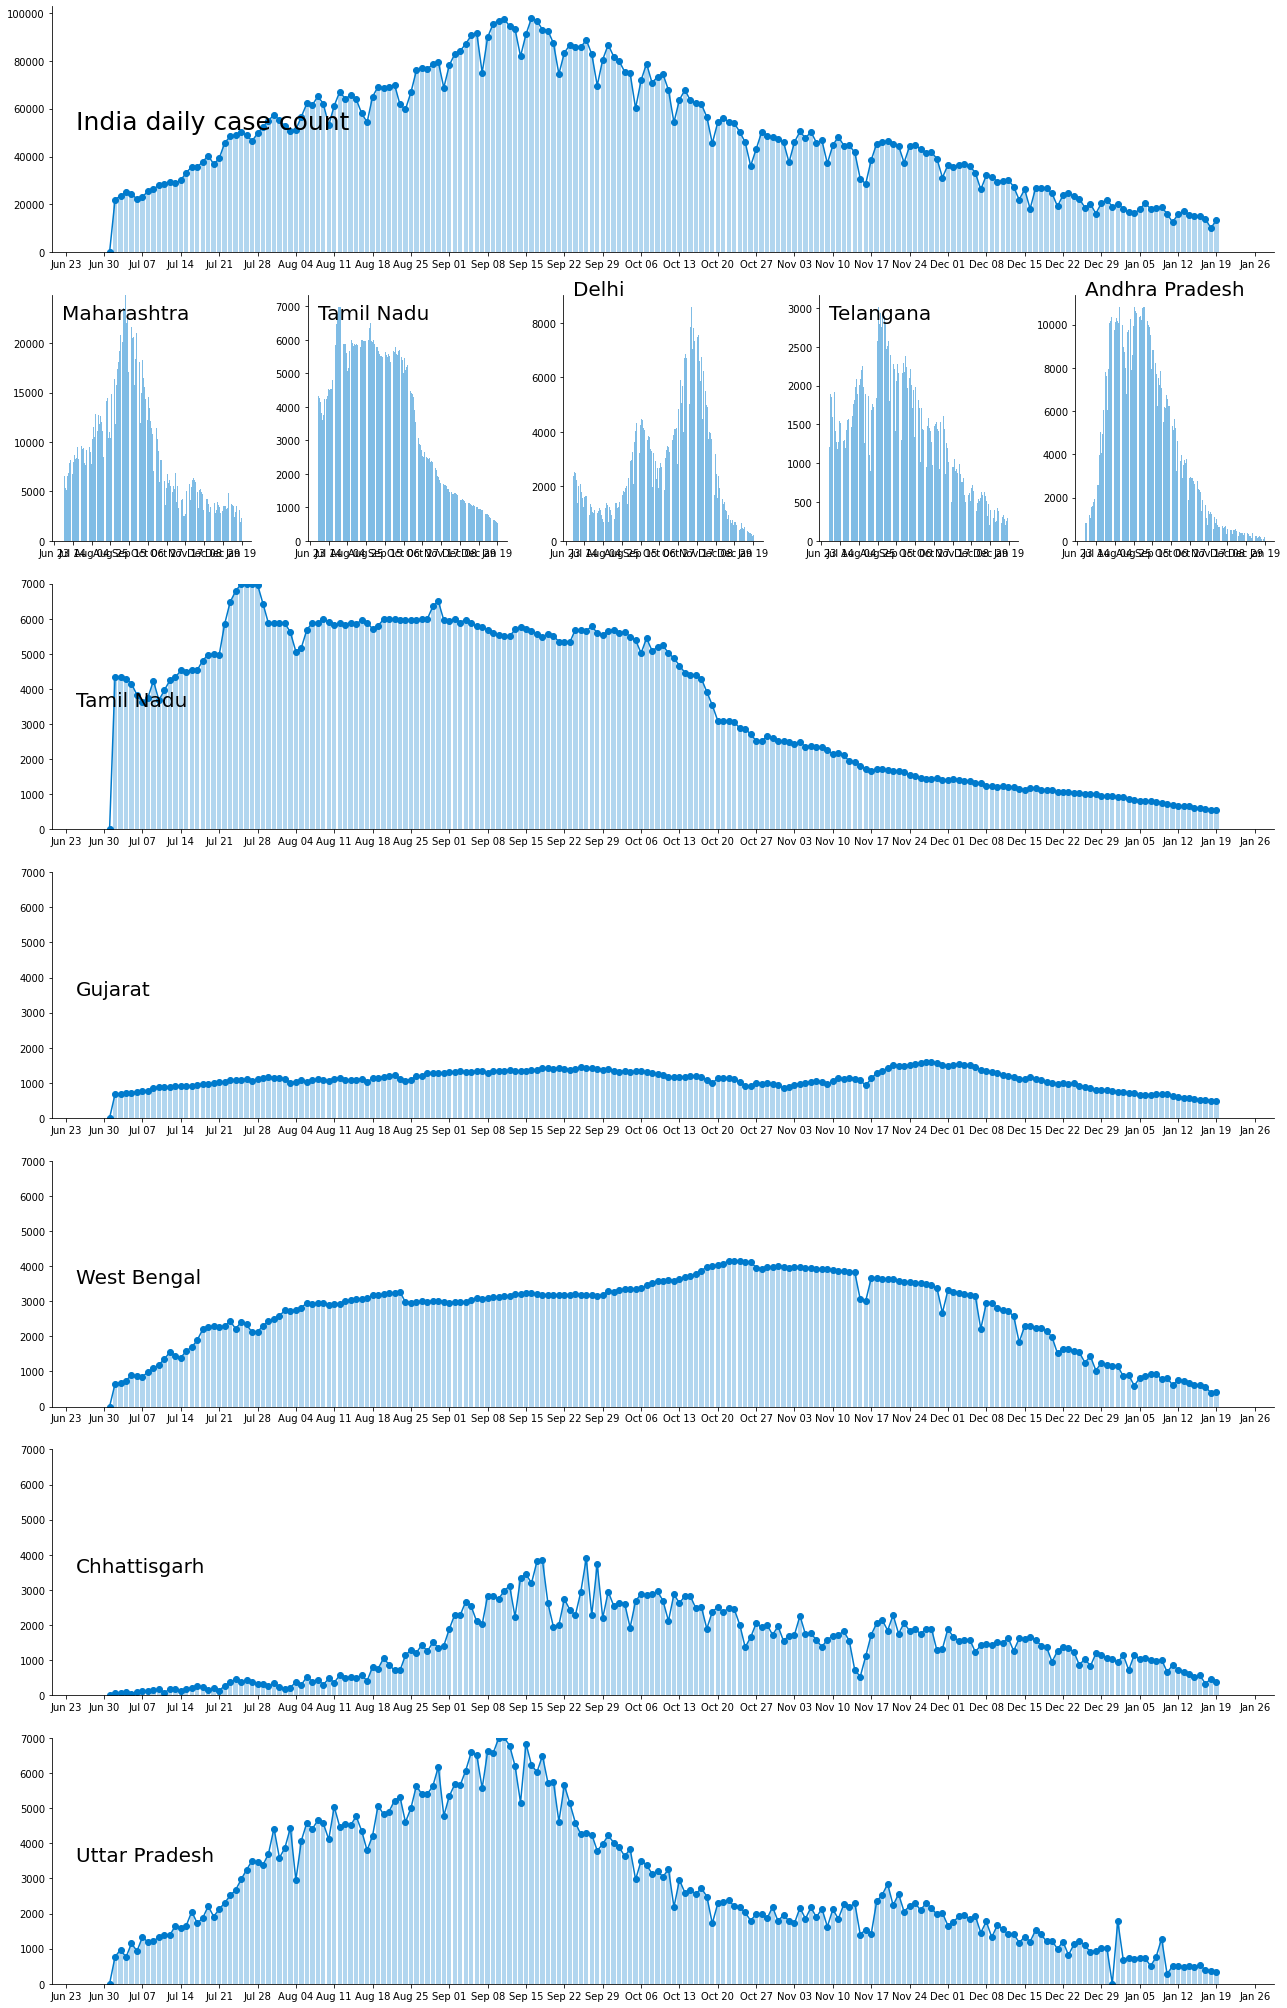

In [19]:
#hide_input
df = dft_ct_new_cases.copy()
df.loc['Total'] = df.sum()
n = 5
ax = []
fig = plt.figure(figsize = (18,28))
gs = fig.add_gridspec(n+2, 5)
# gs = fig.add_gridspec(2, 3)
ax1 = fig.add_subplot(gs[0, :])
ef = df.loc['Total'].rename_axis('date').reset_index()
ef['date'] = ef['date'].astype('datetime64[ns]')
ax1.bar(ef.date,ef.Total,alpha=0.3,color='#007acc')
ax1.plot(ef.date,ef.Total , marker="o", color='#007acc')
ax1.xaxis.set_major_locator(mdates.WeekdayLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax1.text(0.02, 0.5,'India daily case count', transform = ax1.transAxes, fontsize=25);
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax2 = fig.add_subplot(gs[1,0])
ef = df.loc['Maharashtra'].rename_axis('date').reset_index()
ef['date'] = ef['date'].astype('datetime64[ns]')

ax2.bar(ef.date, ef.Maharashtra,color = '#007acc',alpha=0.5)
ax2.xaxis.set_major_locator(mdates.WeekdayLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax2.set_xticks(ax2.get_xticks()[::3])
maxyval = ef.Maharashtra.max()
ax2.set_ylim([0,maxyval])
ax2.text(0.05, 0.9,'Maharashtra', transform = ax2.transAxes, fontsize=20);
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)


ax3 = fig.add_subplot(gs[1,1])
ef = df.loc['Tamil Nadu'].rename_axis('date').reset_index()
ef['date'] = ef['date'].astype('datetime64[ns]')
ax3.bar(ef.date, ef['Tamil Nadu'],color = '#007acc',alpha=0.5,)
ax3.xaxis.set_major_locator(mdates.WeekdayLocator())
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax3.set_xticks(ax3.get_xticks()[::3])
ax3.text(0.05, 0.9,'Tamil Nadu', transform = ax3.transAxes, fontsize=20);
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

ax5 = fig.add_subplot(gs[1,3])
ef = df.loc['Telangana'].rename_axis('date').reset_index()
ef['date'] = ef['date'].astype('datetime64[ns]')
ax5.bar(ef.date, ef['Telangana'],color = '#007acc',alpha=0.5,)
ax5.xaxis.set_major_locator(mdates.WeekdayLocator())
ax5.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax5.set_xticks(ax5.get_xticks()[::3])
ax5.text(0.05, 0.9,'Telangana', transform = ax5.transAxes, fontsize=20);
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)

ax6 = fig.add_subplot(gs[1,4])
ef = df.loc['Andhra Pradesh'].rename_axis('date').reset_index()
ef['date'] = ef['date'].astype('datetime64[ns]')
ax6.bar(ef.date, ef['Andhra Pradesh'],color = '#007acc',alpha=0.5,)
ax6.xaxis.set_major_locator(mdates.WeekdayLocator())
ax6.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax6.set_xticks(ax6.get_xticks()[::3])
ax6.text(0.05, 1,'Andhra Pradesh', transform = ax6.transAxes, fontsize=20);
ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)

ax4 = fig.add_subplot(gs[1,2])
ef = df.loc['Delhi'].rename_axis('date').reset_index()
ef['date'] = ef['date'].astype('datetime64[ns]')
ax4.bar(ef.date, ef.Delhi,color = '#007acc',alpha=0.5)
ax4.set_xticks([])
ax4.xaxis.set_major_locator(mdates.WeekdayLocator())
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax4.set_xticks(ax4.get_xticks()[::3])
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)

ax4.text(0.05, 1,'Delhi', transform = ax4.transAxes, fontsize=20)

for i in range(n):
    
    ax.append(fig.add_subplot(gs[i+2,:]))
    ef = df.iloc[i+3].rename_axis('date').reset_index()
    ef['date'] = ef['date'].astype('datetime64[ns]')
    ax[i].bar(ef.date,ef.iloc[:,-1],color = '#007acc',alpha=0.3)
    ax[i].plot(ef.date,ef.iloc[:,-1],marker='o',color='#007acc')
    ax[i].text(0.02,0.5,f'{ef.columns.values[-1]}',transform = ax[i].transAxes, fontsize = 20);
    ax[i].xaxis.set_major_locator(mdates.WeekdayLocator())
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax[i].set_ylim([0,7000])
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
plt.tight_layout()


In [20]:
#hide_input
print(df_table.to_string(index=False))

                                   states    Cases  Deaths   PCases  PDeaths  Cases (+)  Deaths (+)  Fatality Rate
                              Maharashtra  1994977   50523  1992683    50473       2294          50           2.53
                                Karnataka   933077   12181   932432    12175        645           6           1.31
                           Andhra Pradesh   886245    7142   886066     7141        179           1           0.81
                                   Kerala   857381    3507   851195     3481       6186          26           0.41
                               Tamil Nadu   831866   12281   831323    12272        543           9           1.48
                                    Delhi   632821   10764   632590    10754        231          10           1.70
                            Uttar Pradesh   597238    8584   596904     8580        334           4           1.44
                              West Bengal   566073   10074   565661    10063    